# Inverted File Index

In [1]:
using HDF5
using BenchmarkTools
using Distances
using LoopVectorization
using SIMD
using Clustering
using ProgressMeter
using StaticArrays
using DataFrames
using Plots
using NPZ

## Loading SIFT1M dataset

In [2]:
#path = joinpath(homedir(), "Datasets", "SIFT1M",  "sift-128-euclidean.hdf5")
path = joinpath(homedir(), "TFM", "ann-benchmarks",  "sift-128-euclidean.hdf5")

"/home/adegaray/TFM/ann-benchmarks/sift-128-euclidean.hdf5"

In [3]:
f = h5open(path, "r")

X_tr_vecs = read(f["train"])
X_te_vecs = read(f["test"]);
true_neighbors = read(f["neighbors"])
true_distances = read(f["distances"])

true_neighbors .= true_neighbors .+ 1;

@show size(X_tr_vecs)
@show size(X_te_vecs)
@show size(true_neighbors)
@show size(true_distances)

n_features, n_examples = size(X_tr_vecs)

size(X_tr_vecs) = (128, 1000000)
size(X_te_vecs) = (128, 10000)
size(true_neighbors) = (100, 10000)
size(true_distances) = (100, 10000)


(128, 1000000)

## Generating shared PQ-codes

In [4]:
function encode_shared(dist, vector::Array{T}, shared_prototypes::Array{T}) where T
    n_clusters = length(shared_prototypes)
    n_features = size(vector)[1]
    closest_prototypes = Array{Int8}(undef, n_features, 1);
    
    @inbounds for (j,x) in enumerate(vector)
        best_coordinate = 1
        min_distance::T = typemax(T)
        for k in 1:n_clusters
           current_dist = dist(shared_prototypes[k], x)
           if current_dist < min_distance
               best_coordinate = k
               min_distance = current_dist
           end
           #println(k, ' ', j, ' ', best_coordinate, ' ',min_distance )
        end            
        closest_prototypes[j] = best_coordinate
    end
    return closest_prototypes
end

encode_shared (generic function with 1 method)

In [5]:
P_shared = vec(Float32.(npzread("1dkmeans_prototypes/1dkmeans_shared_prototypes_SIFT1M.npy")))

32-element Vector{Float32}:
   0.22927776
   2.4602568
   4.935903
   7.958296
  10.961814
  13.964964
  16.974878
  19.983488
  23.455843
  27.45342
   ⋮
  94.42536
 100.457985
 106.51546
 112.64925
 118.534
 124.41393
 130.70255
 138.0879
 148.98564

In [6]:
PQcodes_shared = Array{Int8}(undef, n_features, n_examples);

for j in 1:n_examples
    PQcodes_shared[:,j] = encode_shared(euclidean, X_tr_vecs[:,j], P_shared)  
end

## IVF indexer

In [7]:
function ivf_indexer(X, PQcodes, n_cells, clustering_function)
    n_features, n_examples = size(X)

    result = clustering_function(X, n_cells)
    centroids = result.centers
    cell_ids = result.assignments
    
    cells = Vector{Matrix{Int8}}(undef, n_cells)
    pq_ids = Vector{Vector{Int32}}(undef, n_cells)
    @inbounds @fastmath for i in 1:n_cells
        pq_idx = findall(x -> x == i,cell_ids) 
        cells[i] = PQcodes[:,pq_idx]
        pq_ids[i] =  pq_idx 
    end
    return centroids, cells, pq_ids
end

ivf_indexer (generic function with 1 method)

In [20]:
n_cells = 100
clustering_function = kmeans
centroids, cells, indexes  = ivf_indexer(X_tr_vecs, PQcodes_shared, n_cells, clustering_function)

(Float32[8.316579 28.017492 … 21.22518 21.160572; 6.5575085 26.10715 … 22.305256 22.090143; … ; 7.3730087 16.90233 … 11.668127 19.028286; 12.193442 10.227671 … 8.807278 13.996285], Matrix{Int8}[[1 1 … 1 3; 3 1 … 1 2; … ; 15 3 … 3 1; 5 1 … 4 3], [1 7 … 16 16; 14 12 … 23 8; … ; 5 4 … 7 8; 2 13 … 22 4], [11 1 … 1 1; 9 6 … 2 1; … ; 5 1 … 1 4; 19 3 … 5 9], [15 8 … 30 17; 19 6 … 1 13; … ; 10 12 … 7 9; 3 2 … 3 4], [1 1 … 21 22; 1 1 … 1 14; … ; 13 8 … 1 8; 8 12 … 1 4], [6 5 … 1 6; 12 15 … 2 14; … ; 8 10 … 10 5; 11 8 … 11 10], [26 28 … 19 17; 20 1 … 14 1; … ; 2 1 … 2 1; 2 4 … 2 8], [2 2 … 1 1; 2 2 … 1 1; … ; 3 3 … 2 1; 10 10 … 18 8], [19 22 … 30 27; 11 10 … 1 1; … ; 12 12 … 3 4; 13 13 … 3 7], [6 22 … 16 17; 14 3 … 16 14; … ; 12 8 … 23 20; 9 2 … 10 16]  …  [29 31 … 11 10; 3 2 … 3 1; … ; 12 14 … 4 10; 10 7 … 6 15], [22 25 … 25 18; 10 7 … 15 5; … ; 19 21 … 3 3; 2 3 … 1 1], [6 11 … 13 1; 7 7 … 1 1; … ; 3 2 … 1 1; 2 5 … 2 3], [4 18 … 12 14; 10 1 … 8 14; … ; 20 12 … 24 4; 1 20 … 7 1], [17 19 … 7 7; 1

## IVF search

We define some standard

In [9]:
function recall(predicted, relevant, eval_at)
    """
    fraction of the relevant documents that are successfully retrieved
    """
    if eval_at == 0
        return 0.0
    end
    
    predicted_at_k = predicted[1:eval_at]
    n_predicted_and_relevant =  length(intersect( Set(predicted_at_k), Set(relevant))) 
    return n_predicted_and_relevant/ length(relevant)
end

function Euclidean0(x, query)
    @assert length(x) == length(query)
    res = zero(eltype(x))
    @inbounds   for j in eachindex(x)
        aux = (query[j] - x[j])
        res += aux * aux
    end
    return sqrt(res)
end


function adc_dist_shared( x_code,  adc_table::Matrix)
    res = zero(eltype(adc_table))
    @inbounds @simd for j in eachindex(x_code)
        res+= adc_table[x_code[j], j]
    end
    return res
end

function compute_ADC_shared(query, prototypes, dist)
    """
    Computes the distance between each query[k] and prototype[k]
    
    Arguments:
    
    - y (Array{T}): vector of n_features components.
    - prototypes (Array{T}): vector of n_cluster components.
    - dist (function): distance to be used to compare prototypes and query.
    
    """
    #@assert ndims(prototypes) ==1
    
    n_features = length(query)
    n_clusters = length(prototypes)
    ADC_table = Array{Float32}(undef, n_clusters, n_features)
    
    for j in 1:n_features       # 128
        for p in 1:n_clusters   # 32
            ADC_table[p,j] = dist(query[j], prototypes[p] )
        end
    end
    @assert ndims(ADC_table)==2
    return  ADC_table
end

function abs_dist(y::Array{T}, X::Array{T}, j) where T
    # Here I use a bigger Int type than 8 due to avoid
    # res beeing overflowed
    res = Int16(0)
    @inbounds @fastmath  for k in eachindex(y)
        res += abs(X[k, j] - y[k])
    end
    return res
end


function euclidean_mat2(y, X, j) where T
    # Here I use a bigger Int type than 8 due to avoid
    # res beeing overflowed
    res = zero(eltype(y))
    @inbounds @fastmath  for k in eachindex(y)
        partial = X[k, j] - y[k]
        res += partial * partial
    end
    return res
end

euclidean_mat2 (generic function with 1 method)

In [10]:
function select_cells(n_cells, nprobe, centroids, query, dist)
    distances = Array{Float32}(undef, n_cells)
    for i in 1:n_cells
        distances[i] = dist(query, centroids[:,i]) 
    end
    closest_prototypes = partialsortperm(distances, 1:nprobe)
    best_distances = distances[closest_prototypes]

    return best_distances, closest_prototypes
end


function get_top_distances(query, X, prototypes, cells, indexes, fine_quant_funct, P, top_k, extra_factor, refinement, j)

    real_index = prototypes[j]
    pq_codes = cells[real_index]
    original_ids = indexes[real_index]
    pq_distances = fine_quant_funct(query, pq_codes, P)
    n_to_sort = minimum([top_k*extra_factor, length(pq_distances)])
    top_k_pq = partialsortperm(pq_distances, 1:n_to_sort) 

    #Exact search if refinement is chosen
    if refinement == true
        best_ids = Vector{Int32}(undef, n_to_sort)
        for i in 1:n_to_sort
            id = top_k_pq[i]
            best_ids[i] = original_ids[id]
        end
        pq_distances = linear_scann_exact(query, X[:,best_ids]); #X_tr_vecs in memory, SOLVE THIS ->memmap, HDF5
        top_k_pq = partialsortperm(pq_distances, 1:top_k)
        original_ids = best_ids
    end

    #retrieve original ids and distances of closest vectors
    ids = Vector{Int32}(undef, top_k)
    distances = Vector{Float32}(undef, top_k)
    for i in 1:top_k
        id = top_k_pq[i]
        ids[i] = original_ids[id]
        distances[i] = pq_distances[id]
    end
    return distances, ids
end


function top_distances(query, X, closest_prototypes, cells, indexes, fine_quant_funct, P, top_k, extra_factor, refinement, nprobe)
    result_distances = Vector{Vector{Float32}}(undef, nprobe)
    result_ids = Vector{Vector{Int32}}(undef, nprobe)
    for i in 1:nprobe
        distances, ids = get_top_distances(query, X, closest_prototypes, cells, indexes, fine_quant_funct, P, top_k, extra_factor, refinement, i)
        result_distances[i] = distances
        result_ids[i] = ids
    end
    return result_distances, result_ids
end


function linear_scann_shared_l1(query, PQcodes_shared, P_shared)

    n_features, n_examples = size(PQcodes_shared)
    distances = Array{Float32}(undef, n_examples)
    query_code = encode_shared(euclidean, query, P_shared)
    
    @inbounds @fastmath for j in 1:n_examples
        distances[j] = abs_dist(query_code, PQcodes_shared, j)    
    end
    return distances
end

function linear_scann_shared_ADC(query, PQcodes_shared, P_shared)
    
    n_features, n_examples = size(PQcodes_shared)
    distances = Array{eltype(query)}(undef, n_examples)
    adc_table_shared = compute_ADC_shared(query, P_shared, euclidean)
    
    @inbounds @fastmath for j in 1:n_examples
        distances[j] = adc_dist_shared(view(PQcodes_shared,:,j) ,  adc_table_shared)    
    end
    return distances
end

function linear_scann_exact(query, X)

    n_features, n_examples = size(X)
    distances = Array{Float32}(undef, n_examples)
    
    @inbounds for j in 1:n_examples
        distances[j] = euclidean_mat2(query, X, j)    
    end
    return distances
end


function priority_queue_sort(distances, ids, top_k)
    top_k_distances = distances[1]
    top_k_vectors = ids[1]
    for k in 2:length(distances)
        for i in 1:length(distances[k])
            if distances[k][i] < top_k_distances[top_k]
                j = top_k
                while distances[k][i] < top_k_distances[j-1]
                    j = j-1
                    if j == 1
                        break
                    end
                end
                top_k_distances_fixed = copy(top_k_distances)
                top_k_vectors_fixed = copy(top_k_vectors)
                for element in j+1:top_k
                    top_k_distances[element] = top_k_distances_fixed[element-1]
                    top_k_vectors[element] = top_k_vectors_fixed[element-1]
                end
                top_k_distances[j] = distances[k][i]
                top_k_vectors[j] = ids[k][i]
            else
                break
            end
        end
    end
    return top_k_distances, top_k_vectors
end

priority_queue_sort (generic function with 1 method)

In [11]:
function ivf_search(query, X, centroids, cells, indexes, dist, nprobe, PQcodes, P, fine_quant_funct, top_k, extra_factor, refinement)

    if refinement == false
        @assert extra_factor==1
    end

    #Get nprobe closest centroids 
    n_cells = length(cells)
    best_distances, closest_prototypes = select_cells(n_cells, nprobe, centroids, query, dist)
    
    #Get top_k distances in each selected cell
    result_distances, result_ids = top_distances(query, X, closest_prototypes, cells, indexes, fine_quant_funct, P, top_k, extra_factor, refinement, nprobe)
     
    #Get top_k closest distances
    top_k_distances, top_k_vectors = priority_queue_sort(result_distances, result_ids, top_k)

    return top_k_distances, top_k_vectors
end

ivf_search (generic function with 1 method)

In [21]:
query_id = 1
query = X_te_vecs[:,query_id];
query_true_neighbors = true_neighbors[:,query_id]
X = X_tr_vecs
top_k = 100
nprobe = 5
dist = Euclidean0
refinement = true
extra_factor = 10
fine_quant_funct = linear_scann_shared_l1
#fine_quant_funct = linear_scann_shared_ADC

top_k_distances, top_k_vectors = ivf_search(query, X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement)
@show recall(top_k_vectors, query_true_neighbors, top_k)

recall(top_k_vectors, query_true_neighbors, top_k) = 0.98


0.98

In [22]:
@benchmark ivf_search($query, $X, $centroids, $cells, $indexes, $Euclidean0, $nprobe, $PQcodes_shared, $P_shared, $fine_quant_funct, $top_k, $extra_factor, $refinement)

BenchmarkTools.Trial: 1395 samples with 1 evaluation.
 Range (min … max):  2.562 ms …  14.392 ms  ┊ GC (min … max): 0.00% … 67.96%
 Time  (median):     3.393 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.565 ms ± 855.650 μs  ┊ GC (mean ± σ):  1.15% ±  4.94%

     ▁▆▆█▄▁▁▁▁   ▁      ▁                                      
  ▃▅▆███████████▇██▆▇▆▆██▆▆▇▇▇▇▄▅▆▅▄▄▃▄▄▃▃▃▃▂▃▃▃▂▂▃▃▂▂▂▁▂▂▁▁▂ ▄
  2.56 ms         Histogram: frequency by time        5.84 ms <

 Memory estimate: 3.35 MiB, allocs estimate: 7705.

In [23]:
query_id = 1
query = X_te_vecs[:,query_id];
query_true_neighbors = true_neighbors[:,query_id]
X = X_tr_vecs
top_k = 100
nprobe = 20
dist = Euclidean0
refinement = true
extra_factor = 10
fine_quant_funct = linear_scann_shared_l1

function compute_mean_recall_and_time_IVF(Q, X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement)
    n_features, n_examples = size(Q)
    rec = 0.
    t1 = 0.
    t2 = 0.
    t3 = 0.
    for query_id in 1:n_examples
        query = Q[:, query_id]
        query_true_neighbors = true_neighbors[:,query_id]
        #Get nprobe closest centroids 
        n_cells = length(cells)
        t = @elapsed best_distances, closest_prototypes = select_cells(n_cells, nprobe, centroids, query, dist)
        t1 += t;
        
        #Get top_k distances in each selected cell
        t = @elapsed result_distances, result_ids = top_distances(query, X, closest_prototypes, cells, indexes, fine_quant_funct, P_shared, top_k, extra_factor, refinement, nprobe)
        t2 += t;
        #Get top_k closest distances
        t = @elapsed top_k_distances, top_k_vectors = priority_queue_sort(result_distances, result_ids, top_k)
        t3 += t;
        r = recall(top_k_vectors, query_true_neighbors, top_k);
        rec += r;
        end
    return rec/n_examples, t1/n_examples, t2/n_examples, t3/n_examples
    end

avg_recall, avg_time1, avg_time2, avg_time3 = compute_mean_recall_and_time_IVF(X_te_vecs[:, 1:100], X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement) 

(0.9905999999999997, 4.592699999999999e-5, 0.022398386999999995, 2.373e-5)

## Plots for n_cells = 100

In [24]:
recall_array_100 = []
times_100_1 = []
times_100_2 = []
times_100_3 = []
for nprobe in 1:20
    avg_recall, avg_time1, avg_time2, avg_time3 = compute_mean_recall_and_time_IVF(X_te_vecs[:, 1:100], X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement) 
    push!(recall_array_100, avg_recall)
    push!(times_100_1, avg_time1)
    push!(times_100_2, avg_time2)
    push!(times_100_3, avg_time3)
end

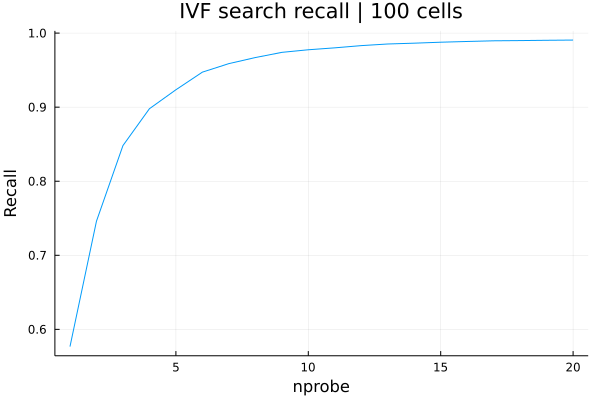

In [25]:
x = 1:20
y = recall_array_100
plot(x, y, title = "IVF search recall | 100 cells", legend = false)
xlabel!("nprobe")
ylabel!("Recall")

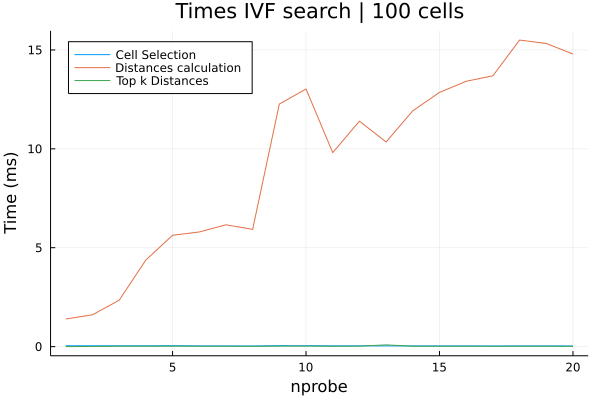

In [26]:
y = [times_100_1*1000, times_100_2*1000, times_100_3*1000]
plot(x, y, title = "Times IVF search | 100 cells", label = ["Cell Selection" "Distances calculation" "Top k Distances"], legend=:topleft)
xlabel!("nprobe")
ylabel!("Time (ms)")

Let us look into the times for each function involved in the distance calculation:

In [56]:
nprobe = 10
i = 10
best_distances, closest_prototypes = select_cells(n_cells, nprobe, centroids, query, dist)
@benchmark get_top_distances(query, X, closest_prototypes, cells, indexes, fine_quant_funct, P_shared, top_k, extra_factor, refinement, i)

BenchmarkTools.Trial: 7660 samples with 1 evaluation.
 Range (min … max):  368.000 μs …  18.769 ms  ┊ GC (min … max): 0.00% … 92.62%
 Time  (median):     450.700 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   642.815 μs ± 534.237 μs  ┊ GC (mean ± σ):  1.68% ±  3.21%

  ██▅▅▅▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁ ▁▁                                       ▂
  █████████████████████████████▇▇▇▇█▇▇▇█▆▇▇▇▆▇▇▆▅▅▆▆▆▆▅▆▅▆▃▅▅▅▅ █
  368 μs        Histogram: log(frequency) by time       2.42 ms <

 Memory estimate: 642.45 KiB, allocs estimate: 1507.

In [57]:
real_index = closest_prototypes[i]
pq_codes = cells[real_index]
original_ids = indexes[real_index]
@benchmark pq_distances = fine_quant_funct(query, pq_codes, P_shared)  

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  55.300 μs … 681.100 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     57.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   62.987 μs ±  16.374 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆█▅▆▄▂▃▃▂▁▁                                                  ▁
  ███████████████▇▇▆▆▇▇▆▇▇▆▆▇▇▇▇▇▆▆▆▇▆▇▇▆▇▆▇▅▆▇▅▆▆▆▅▅▅▆▅▆▅▄▅▅▅ █
  55.3 μs       Histogram: log(frequency) by time       134 μs <

 Memory estimate: 34.11 KiB, allocs estimate: 3.

In [58]:
pq_distances = fine_quant_funct(query, pq_codes, P_shared)  
n_to_sort = minimum([top_k*extra_factor, length(pq_distances)])
@benchmark top_k_pq = partialsortperm(pq_distances, 1:n_to_sort) 

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  150.700 μs …  5.437 ms  ┊ GC (min … max): 0.00% … 95.35%
 Time  (median):     161.300 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   174.013 μs ± 63.397 μs  ┊ GC (mean ± σ):  0.30% ±  0.95%

  ▆▇▅█▆▄▅▅▃▁▁                                                  ▂
  █████████████████████████▇██████▇█▇█▆▇▇▇█▇▇▇▇▇▇▆▇▆▆▇▇▆▅▆▆▅▅▆ █
  151 μs        Histogram: log(frequency) by time       321 μs <

 Memory estimate: 67.92 KiB, allocs estimate: 6.

In [59]:
top_k_pq = partialsortperm(pq_distances, 1:n_to_sort) 
best_ids = Vector{Int32}(undef, n_to_sort)
for i in 1:n_to_sort
    id = top_k_pq[i]
    best_ids[i] = original_ids[id]
end

@benchmark linear_scann_exact(query, X[:,best_ids])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  133.700 μs …   6.092 ms  ┊ GC (min … max): 0.00% … 91.33%
 Time  (median):     152.600 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   196.990 μs ± 190.606 μs  ┊ GC (mean ± σ):  2.67% ±  3.03%

  ▇█▆▆▄▄▄▄▃▃▃▂▂▁▁ ▂▂▂▁▁               ▁                         ▂
  ███████████████████████▇▇████████████████▇█▇▇▇▇▇▇▇▅▇▆▆▆▇▇▆▅▆▆ █
  134 μs        Histogram: log(frequency) by time        539 μs <

 Memory estimate: 527.39 KiB, allocs estimate: 1493.

In [60]:
pq_distances = linear_scann_exact(query, X[:,best_ids])
@benchmark top_k_pq = partialsortperm(pq_distances, 1:top_k)

BenchmarkTools.Trial: 10000 samples with 5 evaluations.
 Range (min … max):  6.280 μs … 481.400 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.140 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.862 μs ±   6.420 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▂                                                          
  ████▆▄▃▃▃▃▃▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  6.28 μs         Histogram: frequency by time        25.9 μs <

 Memory estimate: 8.06 KiB, allocs estimate: 5.

## Plots for n_cells = 256

In [17]:
recall_array_256 = []
times_256_1 = []
times_256_2 = []
times_256_3 = []
for nprobe in 1:20
    avg_recall, avg_time1, avg_time2, avg_time3 = compute_mean_recall_and_time_IVF(X_te_vecs[:, 1:100], X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement) 
    push!(recall_array_256, avg_recall)
    push!(times_256_1, avg_time1)
    push!(times_256_2, avg_time2)
    push!(times_256_3, avg_time3)
end

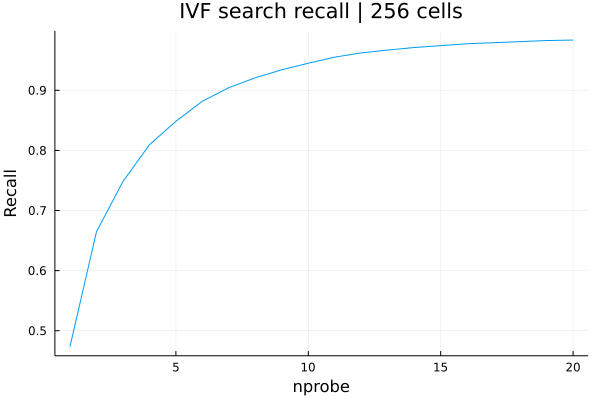

In [18]:
x = 1:20
y = recall_array_256
plot(x, y, title = "IVF search recall | 256 cells", legend = false)
xlabel!("nprobe")
ylabel!("Recall")

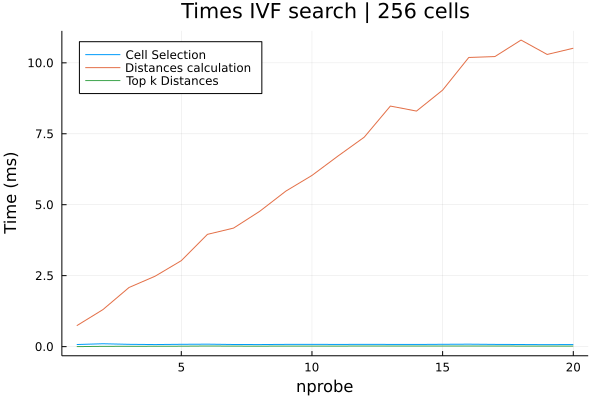

In [19]:
y = [times_256_1*1000, times_256_2*1000, times_256_3*1000]
plot(x, y, title = "Times IVF search | 256 cells", label = ["Cell Selection" "Distances calculation" "Top k Distances"], legend=:topleft)
xlabel!("nprobe")
ylabel!("Time (ms)")

## Plots for n_cells = 1000

In [84]:
recall_array_1000 = []
times_1000_1 = []
times_1000_2 = []
times_1000_3 = []
for nprobe in 1:20
    avg_recall, avg_time1, avg_time2, avg_time3 = compute_mean_recall_and_time_IVF(X_te_vecs[:, 1:100], X, centroids, cells, indexes, dist, nprobe, PQcodes_shared, P_shared, fine_quant_funct, top_k, extra_factor, refinement) 
    push!(recall_array_1000, avg_recall)
    push!(times_1000_1, avg_time1)
    push!(times_1000_2, avg_time2)
    push!(times_1000_3, avg_time3)
end

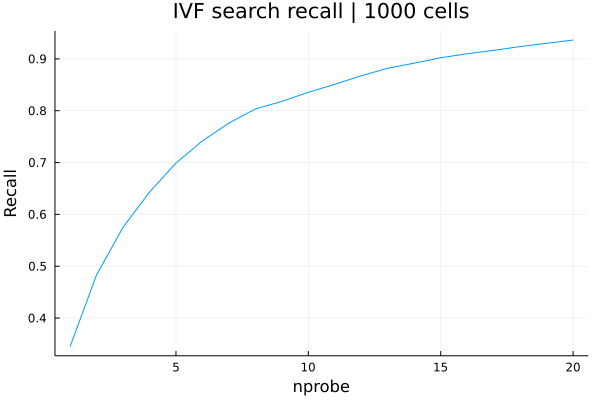

In [83]:
x = 1:20
y = recall_array_1000
plot(x, y, title = "IVF search recall | 1000 cells", legend = false)
xlabel!("nprobe")
ylabel!("Recall")

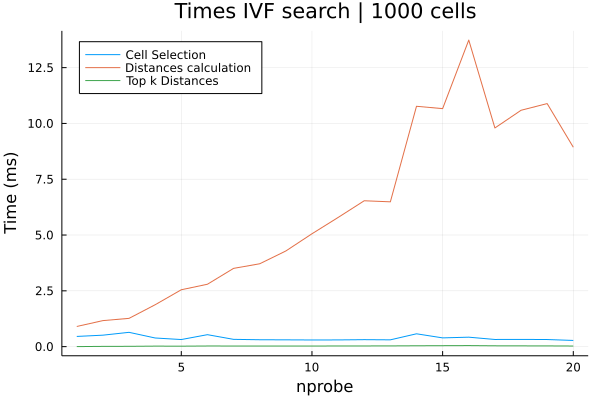

In [82]:
y = [times_1000_1*1000, times_1000_2*1000, times_1000_3*1000]
plot(x, y, title = "Times IVF search | 1000 cells", label = ["Cell Selection" "Distances calculation" "Top k Distances"], legend=:topleft)
xlabel!("nprobe")
ylabel!("Time (ms)")